<h1>Exercício 1</h1>
<BR>
<h2>
Classificação (clusterização) dos clientes a partir dos dados informados por eles a WTEC.
</h2>

# Bibliotecas

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')


# Funções Auxiliares

In [25]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100


def spider_plot_rt(data, cluster):
    NaN_array = np.empty((4))
    NaN_array[:] = np.NaN
    means = np.c_[data.groupby('kmeans').mean().to_numpy(), NaN_array]
    names = np.r_[data.columns[0:-1], ['']]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection="polar")
    ax.plot(label_loc, means[cluster], label=f'class {categories[cluster]}')
    ax.set_title(f'Cluster {cluster}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.show()    
    

# Carregando os Dados

## Vamos utilizar nesta análise a base montada no notebook de análise inicial do dados, com os dados de DRE completos.

In [3]:

df = pd.read_csv("./df_pre_processado.csv")

In [4]:
explore(df)

dtypes  count  null_sum  null_pct  nunique  \
anoFundacao                  float64   6012         0     0.000       66   
ativoCirculante              float64   6012         0     0.000     1794   
capitalSocial                float64   6012         0     0.000      298   
cnpjSemTraco                  object   6012         0     0.000     1523   
custos                       float64   6012         0     0.000     1703   
dashboardCorrelacao          float64   6012         0     0.000      519   
dataAprovadoEmComite          object    443      5569     0.926      443   
dataAprovadoNivelAnalista     object   4652      1360     0.226     4652   
definicaoRisco                object   6012         0     0.000        4   
diferencaPercentualRisco     float64   6012         0     0.000       77   
duplicatasAReceber           float64   6012         0     0.000     1668   
empresa_MeEppMei                bool   6012         0     0.000        2   
endividamento                float64   6012         0     0.000     1185   
estoque                      float64   6012         0     0.000     1674   
faturamentoBruto             float64   6012         0     0.000     2605   
intervaloFundacao             object   6012         0     0.000        4   
limiteEmpresaAnaliseCredito  float64   6012         0     0.000     1478   
maiorAtraso                    int64   6012         0     0.000      153   
margemBruta                  float64   6012         0     0.000     1860   
margemBrutaAcumulada         float64   6012         0     0.000     1200   
nomeFantasia                  object   6012         0     0.000     1470   
numero_solicitacao             int64   6012         0     0.000     6012   
passivoCirculante            float64   6012         0     0.000     1789   
percentualProtestos          float64   5045       967     0.161        2   
percentualRisco              float64   6012         0     0.000       79   
periodoBalanco                object   6012         0     0.000      124   
periodoDemonstrativoEmMeses  float64   6012         0     0.000       12   
prazoMedioRecebimentoVendas    int64   6012         0     0.000      149   
primeiraCompra                object   5945        67     0.011     1207   
razaoSocial                   object   6012         0     0.000     1490   
restricoes                      bool   6012         0     0.000        2   
scorePontualidade            float64   6012         0     0.000      285   
status                        object   6012         0     0.000        7   
titulosEmAberto              float64   6012         0     0.000      563   
totalAtivo                   float64   6012         0     0.000     1788   
totalPatrimonioLiquido       float64   6012         0     0.000     1759   
valorAprovado                float64   5095       917     0.153      287   
valorSolicitado              float64   6012         0     0.000      318   

                                                   min         25%        50%  \
anoFundacao                                     1000.0      2000.0     2008.5   
ativoCirculante                                  -17.0    529853.0  3230248.0   
capitalSocial                                      0.0     95400.0   200000.0   
cnpjSemTraco                        AADG56617962174727           -          -   
custos                                    -346633805.0         0.0  1723174.0   
dashboardCorrelacao                           -0.99999         0.0        0.0   
dataAprovadoEmComite                                 -           -          -   
dataAprovadoNivelAnalista                            -           -          -   
definicaoRisco               De 0 a 10 % - Muito Baixo           -          -   
diferencaPercentualRisco                      0.207547    0.679245   0.785714   
duplicatasAReceber                         -22780710.0         0.0   878819.0   
empresa_MeEppMei                                 False         0.0        0.0   
endividament

<h1>
Retirando as variáveis que não iremos usar na análise de clusters.<BR>
<BR>
Entendemos que a análise requisitada pela empresa WTEC é para classificarmos os seus clientes em grupos antes de qualquer análise pela empresa.<BR>
Para isso não iremos usar nenhum dado que tenha sido gerado pela WTEC.<BR>
</h1>
<h2>
1) numero_solicitação - não necessitamos de um index.<BR>
2) percentualProtestos - esta variável náo ajuda a explicar o problema pois possue 83% de zeros e 16,7% de nulos. Sobrando apenas 0,3% de dados válidos.<BR>
3) diferencaPercentualRisco - mesmos valores do percentualRisco.<BR>
4) dashboardCorrelacao - Não entedemos o seu objetivo.<BR>
5) Todas as variáveis de data, deixando apenas o ano da fundação (numérico).<BR>
6) As variáveis categoricas, como nome fantasia e razão social.<BR>
7) Todas as variáveis que foram geradas pela WTEC, como scorePontualidade e percentualRisco.
</h2>

In [5]:
df.drop(['scorePontualidade', 'maiorAtraso', 'valorAprovado', 'valorSolicitado', 'dataAprovadoEmComite', 'dataAprovadoNivelAnalista', 'numero_solicitacao',
         'razaoSocial', 'nomeFantasia', 'status', 'definicaoRisco', 'anoFundacao', 'diferencaPercentualRisco', 'dashboardCorrelacao', 'percentualRisco',
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'percentualProtestos', 'margemBrutaAcumulada'], axis=1, inplace=True)

<h2>
Vamos retirar todos os CNPJs duplicados, pois queremos formar clusters com CNPJs únicos.<BR>
Para esta análise vamos manter sempre a entrada mais atualizada de cada cliente, a última dentro da base, pois a mesma está em ordem cronológica.<BR>
</h2>

In [6]:
df.drop_duplicates(subset='cnpjSemTraco', keep='last', inplace=True)

In [7]:
explore(df)

dtypes  count  null_sum  null_pct  nunique  \
ativoCirculante              float64   1523         0       0.0     1178   
capitalSocial                float64   1523         0       0.0      284   
cnpjSemTraco                  object   1523         0       0.0     1523   
custos                       float64   1523         0       0.0     1033   
duplicatasAReceber           float64   1523         0       0.0     1042   
empresa_MeEppMei                bool   1523         0       0.0        2   
endividamento                float64   1523         0       0.0      636   
estoque                      float64   1523         0       0.0     1105   
faturamentoBruto             float64   1523         0       0.0     1415   
limiteEmpresaAnaliseCredito  float64   1523         0       0.0      861   
margemBruta                  float64   1523         0       0.0     1068   
passivoCirculante            float64   1523         0       0.0     1168   
prazoMedioRecebimentoVendas    int64   1523         0       0.0      149   
restricoes                      bool   1523         0       0.0        2   
titulosEmAberto              float64   1523         0       0.0      563   
totalAtivo                   float64   1523         0       0.0     1180   
totalPatrimonioLiquido       float64   1523         0       0.0     1166   

                                            min        25%        50%  \
ativoCirculante                             0.0   298293.0  2451304.0   
capitalSocial                               0.0    80000.0   150000.0   
cnpjSemTraco                 AADG56617962174727          -          -   
custos                                -431401.0        0.0  1565850.0   
duplicatasAReceber                  -22780710.0        0.0   567455.0   
empresa_MeEppMei                          False        0.0        0.0   
endividamento                               0.0        0.0        0.0   
estoque                                     0.0     8667.5   605595.0   
faturamentoBruto                            0.0  1672928.5  4925896.0   
limiteEmpresaAnaliseCredito                 0.0     9900.0    72600.0   
margemBruta                        -614872100.0        0.0  1364721.0   
passivoCirculante                    -1134941.0    44519.5   779307.0   
prazoMedioRecebimentoVendas                   0        0.0        0.0   
restricoes                                False        0.0        0.0   
titulosEmAberto                             0.0        0.0        0.0   
totalAtivo                                  0.0   364756.0  2846875.0   
totalPatrimonioLiquido             -186719734.0    49100.5  1101916.0   

                                    75%                 max             mean  \
ativoCirculante              11347037.5       29038320000.0  53918426.858831   
capitalSocial                  600000.0        4100000000.0  16456989.209455   
cnpjSemTraco                          -  ZZVU59020803434073                -   
custos                        8736359.0        4393536000.0  41907151.246225   
duplicatasAReceber            3720666.0       20093580000.0  24822958.860801   
empresa_MeEppMei                    1.0                True         0.317137   
endividamento                  410269.0         740631476.0   4856513.224557   
estoque                       3524299.0        1293428000.0  12406042.209455   
faturamentoBruto             21466386.0        6426115000.0  75644114.824688   
limiteEmpresaAnaliseCredito    585091.0        1974261312.0   4148168.915955   
margemBruta                   6838309.5        3366842514.0  24218699.093237   
passivoCirculante             4808169.0       27503820000.0  45592322.526592   
prazoMedioRecebimentoVendas        21.0                1605        20.120158   
restricoes                          0.0                True          0.09849   
titulosEmAberto                  9940.0           2836656.0     40928.155936   
totalAtivo                   12919622.0       54823500000.0  96027

<h3>
Com estes tratamentos já temos uma base sem dados nulos (faltantes) e com apenas um CNPJ de cada cliente.<BR>
Agora vamos retirar o CNPJ da base para continuar a análise.
</h3>

In [8]:
df_num = df.drop(['cnpjSemTraco'], axis=1)

<h3>
Transformando as variáveis booleanas em númericas.
</h3>

In [9]:

df_num.restricoes = df_num.restricoes.apply(lambda x:1 if x else 0)
df_num.empresa_MeEppMei = df_num.empresa_MeEppMei.apply(lambda x:1 if x else 0)


In [10]:
explore(df_num)

dtypes  count  null_sum  null_pct  nunique  \
prazoMedioRecebimentoVendas    int64   1523         0       0.0      149   
titulosEmAberto              float64   1523         0       0.0      563   
ativoCirculante              float64   1523         0       0.0     1178   
passivoCirculante            float64   1523         0       0.0     1168   
totalAtivo                   float64   1523         0       0.0     1180   
totalPatrimonioLiquido       float64   1523         0       0.0     1166   
endividamento                float64   1523         0       0.0      636   
duplicatasAReceber           float64   1523         0       0.0     1042   
estoque                      float64   1523         0       0.0     1105   
faturamentoBruto             float64   1523         0       0.0     1415   
margemBruta                  float64   1523         0       0.0     1068   
custos                       float64   1523         0       0.0     1033   
capitalSocial                float64   1523         0       0.0      284   
restricoes                     int64   1523         0       0.0        2   
empresa_MeEppMei               int64   1523         0       0.0        2   
limiteEmpresaAnaliseCredito  float64   1523         0       0.0      861   

                                     min        25%        50%         75%  \
prazoMedioRecebimentoVendas          0.0        0.0        0.0        21.0   
titulosEmAberto                      0.0        0.0        0.0      9940.0   
ativoCirculante                      0.0   298293.0  2451304.0  11347037.5   
passivoCirculante             -1134941.0    44519.5   779307.0   4808169.0   
totalAtivo                           0.0   364756.0  2846875.0  12919622.0   
totalPatrimonioLiquido      -186719734.0    49100.5  1101916.0   5735235.0   
endividamento                        0.0        0.0        0.0    410269.0   
duplicatasAReceber           -22780710.0        0.0   567455.0   3720666.0   
estoque                              0.0     8667.5   605595.0   3524299.0   
faturamentoBruto                     0.0  1672928.5  4925896.0  21466386.0   
margemBruta                 -614872100.0        0.0  1364721.0   6838309.5   
custos                         -431401.0        0.0  1565850.0   8736359.0   
capitalSocial                        0.0    80000.0   150000.0    600000.0   
restricoes                           0.0        0.0        0.0         0.0   
empresa_MeEppMei                     0.0        0.0        0.0         1.0   
limiteEmpresaAnaliseCredito          0.0     9900.0    72600.0    585091.0   

                                      max          mean     median  \
prazoMedioRecebimentoVendas  1.605000e+03  2.012000e+01        0.0   
titulosEmAberto              2.836656e+06  4.092816e+04        0.0   
ativoCirculante              2.903832e+10  5.391843e+07  2451304.0   
passivoCirculante            2.750382e+10  4.559232e+07   779307.0   
totalAtivo                   5.482350e+10  9.602702e+07  2846875.0   
totalPatrimonioLiquido       1.292328e+10  3.247566e+07  1101916.0   
endividamento                7.406315e+08  4.856513e+06        0.0   
duplicatasAReceber           2.009358e+10  2.482296e+07   567455.0   
estoque                      1.293428e+09  1.240604e+07   605595.0   
faturamentoBruto             6.426115e+09  7.564411e+07  4925896.0   
margemBruta                  3.366843e+09  2.421870e+07  1364721.0   
custos                       4.393536e+09  4.190715e+07  1565850.0   
capitalSocial                4.100000e+09  1.645699e+07   150000.0   
restricoes                   1.000000e+00  9.800000e-02        0.0   
empresa_MeEppMei             1.000000e+00  3.170000e-01        0.0   
limiteEmpresaAnaliseCredito  1.974261e+09  4.148169e+06    72600.0   

                                      std    skew  
prazoMedioRecebimentoVendas  6.307400e+01  12.886  
titulosEmAberto              1.765397e+05   8.188  
ativoCirculante              7.876672e+08  33.697  
passivoCirc

<h3>
Temos agora uma base apenas numérica.<BR>
Vamos olhar a distribuição espacial destes dados, observando a média e desvio padrão de cada variável.
</h3>

In [11]:
fig = px.bar(data_frame = df_num.mean(), height=600, title='Banco de Dados Original - valores médios')
fig.show()

In [12]:
fig = px.bar(data_frame = df_num.std(), height=600, title='Banco de Dados Original - desvio padrão')
fig.show()

<h3>
Observando o gráfico acima percebemos que a escala de cada variável é muito diferente uma da outra.<BR>
Como iremos utilizar o Kmeans para fazer a clusterização, e ele utiliza as distâncias para calcular os clusters, vamos utilizar uma função MinMax para colocar todos os dados entre 0 e 1.<BR>
Não iremos retirar nenhum outlier ou extremo para esta análise pois acreditamos que eles podem formar um cluster.<BR>
</h3>

In [13]:
mmsc = MinMaxScaler().fit(df_num)
df_mmsc = pd.DataFrame(mmsc.transform(df_num), columns=df_num.columns)
df_mmsc

prazoMedioRecebimentoVendas  titulosEmAberto  ativoCirculante  \
0                        0.000000         0.000000         0.000015   
1                        0.039252         0.003655         0.000013   
2                        0.000000         0.000000         0.000025   
3                        0.000000         0.000000         0.000003   
4                        0.000000         0.000000         0.000031   
...                           ...              ...              ...   
1518                     0.017445         0.002399         0.000691   
1519                     0.027414         0.031830         0.000170   
1520                     0.000000         0.000000         0.000000   
1521                     0.039875         0.449989         0.001319   
1522                     0.029283         0.011728         0.000118   

      passivoCirculante  totalAtivo  totalPatrimonioLiquido  endividamento  \
0              0.000051    0.000008                0.014256       0.000000   
1              0.000074    0.000011                0.014278       0.000000   
2              0.000048    0.000013                0.014349       0.000000   
3              0.000052    0.000087                0.014585       0.000000   
4              0.000060    0.000017                0.014277       0.000000   
...                 ...         ...                     ...            ...   
1518           0.000702    0.000370                0.014387       0.000101   
1519           0.000188    0.000103                0.014312       0.001697   
1520           0.000041    0.000000                0.014243       0.000000   
1521           0.000589    0.000746                0.016196       0.000062   
1522           0.000082    0.000070                0.014451       0.000000   

      duplicatasAReceber   estoque  faturamentoBruto  margemBruta    custos  \
0               0.001132  0.000155          0.000097     0.154423  0.000000   
1               0.001139  0.000164          0.000183     0.154424  0.000098   
2               0.001165  0.000000          0.000194     0.154500  0.000595   
3               0.001292  0.000924          0.000835     0.154762  0.000570   
4               0.001132  0.000479          0.000089     0.154424  0.000098   
...                  ...       ...               ...          ...       ...   
1518            0.001693  0.004421          0.020740     0.165628  0.020278   
1519            0.001305  0.001018          0.000760     0.155007  0.000682   
1520            0.001132  0.000000          0.000839     0.154486  0.001269   
1521            0.001917  0.011786          0.018627     0.164115  0.018559   
1522            0.001255  0.000690          0.000731     0.155064  0.000588   

      capitalSocial  restricoes  empresa_MeEppMei  limiteEmpresaAnaliseCredito  
0          0.000010         0.0               1.0                     0.000005  
1          0.000012         0.0               1.0                     0.000022  
2          0.000024         0.0               1.0                     0.000084  
3          0.000122         0.0               1.0                     0.000098  
4          0.000020         0.0               1.0                     0.000032  
...             ...         ...               ...                          ...  
1518       0.000203         0.0               0.0                     0.003647  
1519       0.000007         0.0               0.0                     0.000030  
1520       0.000027         0.0               1.0                     0.000002  
1521       0.000488         0.0               0.0                     0.005487  
1522       0.000068         0.0               0.0                     0.000026  

[1523 rows x 16 columns]

In [14]:
px.box(df_mmsc)

<h2>
Curva de Elbow e Silhouette para determinar o melhor K para o Kmeans.
</h2>

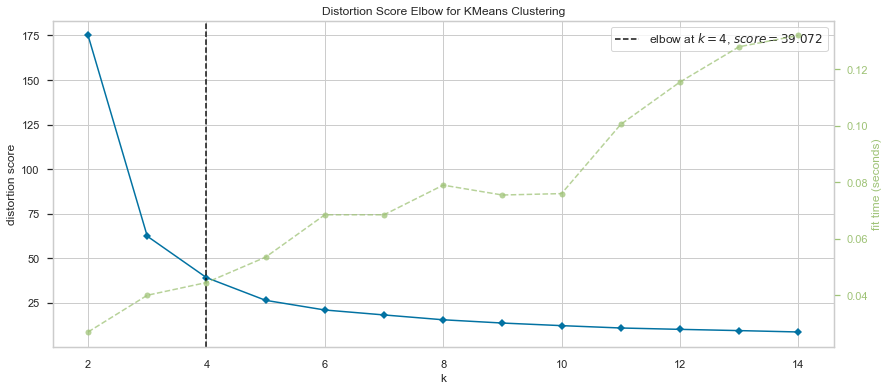

In [15]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

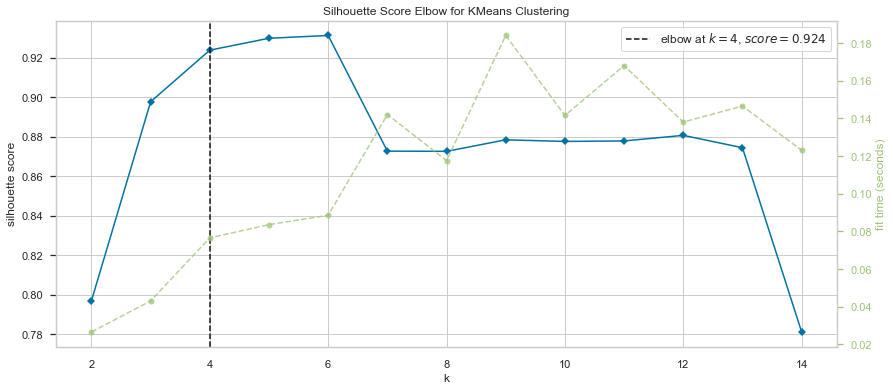

In [16]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, metric='silhouette',k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

<h3>
Conforme os gráficos acima vamos usar um K = 4.
</h3>

In [17]:
km = KMeans(n_clusters=4, n_init=100, max_iter=1000, algorithm='full', random_state=42)
km_labels = km.fit_predict(df_mmsc)

<h3>
Colocando os valores dos clusters nas bases utilizadas.
</h3>

In [18]:
df_num['kmeans'] = km_labels
df_mmsc['kmeans'] = km_labels
df['kmeans'] = km_labels

with pd.ExcelWriter("df_ex1_wtec_excel.xlsx") as writer:
    df.to_excel(writer)

df.to_csv("./df_ex1.csv", index=False)   

<h1>
Avaliação do Modelo
</h1>

<h2>
Vamos usar duas métricas para avaliar o modelo.
</h2>
<h3>
1) O Índice DAVIS-BOULDIN representa a similaridade entre os clusters e a distância dos mais próximos. Os valores variam de 0 para cima, e quanto mais perto de 0 melhor.<BR>
2) O coeficiente Silhouette varia entre -1 e 1. Quanto maior o valor melhor será po modelo. O valor 1 indica clusters bastante definidos e compactos e o valor 0 indica clausters sobrepostos. Valores negativos siginifica que o modelo não está compreendendo os dados.
</h3>

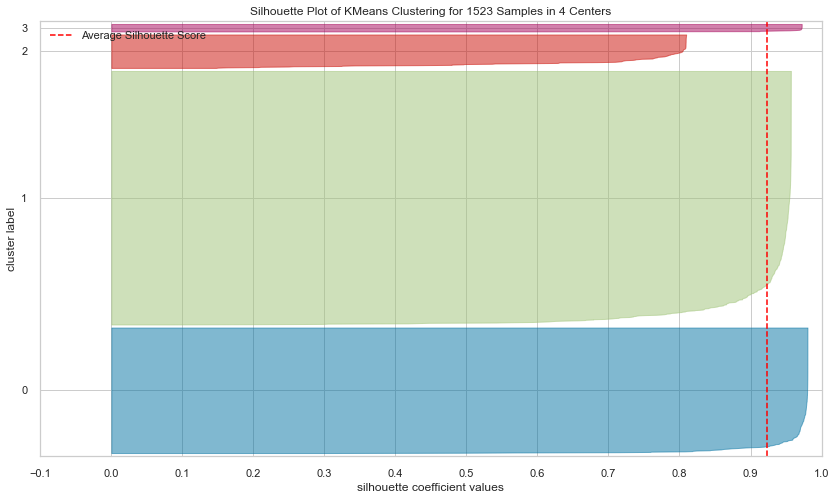

In [19]:
fig = plt.figure(figsize=(14,8))

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_mmsc.drop(['kmeans'],axis=1))
visualizer.show()
plt.show()

In [20]:
print(f'Davies-Bouldin index = {davies_bouldin_score(df_mmsc, km_labels)}')
print(f'Silhouette Score = {silhouette_score(df_mmsc, km_labels)}')

Davies-Bouldin index = 0.18527057745089415
Silhouette Score = 0.9445985718174957


<h2>
Pela métrica acima o nosso modelo performou muito bem.
</h2>

<h2>
Agora a vamos ver os nossos clusters!!!
</h2>

In [21]:
df.groupby('kmeans').titulosEmAberto.count()

kmeans
0    455
1    918
2    122
3     28
Name: titulosEmAberto, dtype: int64

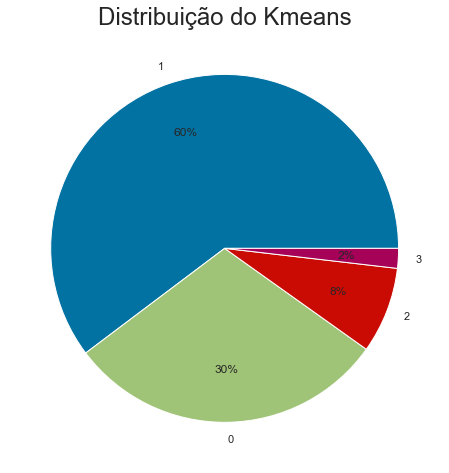

In [22]:
fig = plt.figure(figsize=(8,8))
df.kmeans.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)
plt.title('Distribuição do Kmeans', size=24)
plt.ylabel("")
plt.show()

<h2>
E agora quais variáveis foram mais importantes para a construção de cada cluster.<BR>
As variáveis estão listadas por ordem de importância para a construção do cluster.
</h2>

In [23]:
# todas as variáveis do banco menos a identificação do cluster .
variaveis = df_mmsc.columns.tolist()[:-1]
centroides = np.abs(km.cluster_centers_)
index_variaveis_centroide_ordem = centroides.argsort(axis=1)[:,::-1]
dimensao_variavel_centroide_ordem = np.take_along_axis(centroides, index_variaveis_centroide_ordem, axis=1)

numero_variaveis = 5

for x in range(len(centroides)):
    variaveis_centroide = centroides[x][index_variaveis_centroide_ordem[x]]
    print(f"Cluster {x}")
    for y in range(numero_variaveis):
        print(f"variável: {variaveis[index_variaveis_centroide_ordem[x][y]]} - peso: {round(variaveis_centroide[y], 4)}")
    print('-'*60)    

Cluster 0
variável: empresa_MeEppMei - peso: 1.0
variável: margemBruta - peso: 0.155
variável: totalPatrimonioLiquido - peso: 0.0145
variável: prazoMedioRecebimentoVendas - peso: 0.0118
variável: titulosEmAberto - peso: 0.0087
------------------------------------------------------------
Cluster 1
variável: margemBruta - peso: 0.1586
variável: totalPatrimonioLiquido - peso: 0.0172
variável: titulosEmAberto - peso: 0.0162
variável: prazoMedioRecebimentoVendas - peso: 0.0133
variável: faturamentoBruto - peso: 0.0085
------------------------------------------------------------
Cluster 2
variável: restricoes - peso: 1.0
variável: margemBruta - peso: 0.1967
variável: faturamentoBruto - peso: 0.0774
variável: estoque - peso: 0.07
variável: custos - peso: 0.0694
------------------------------------------------------------
Cluster 3
variável: empresa_MeEppMei - peso: 1.0
variável: restricoes - peso: 1.0
variável: margemBruta - peso: 0.155
variável: titulosEmAberto - peso: 0.0194
variável: total

<h2>
Apresentamos abaixo o SpiderPlot para cada cluster, confirmando o relatório acima.
</h2>

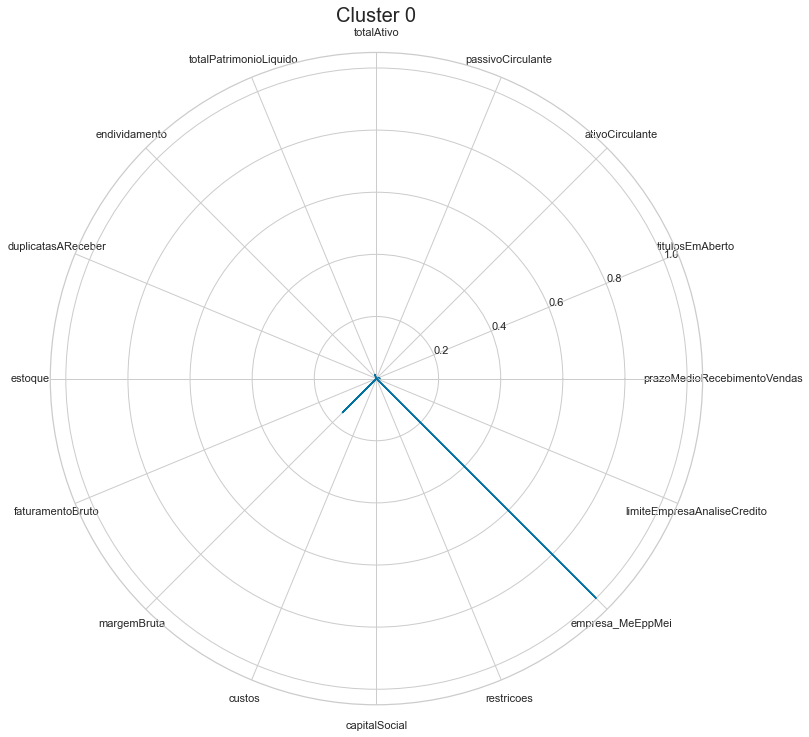

In [26]:
spider_plot_rt(df_mmsc, 0)

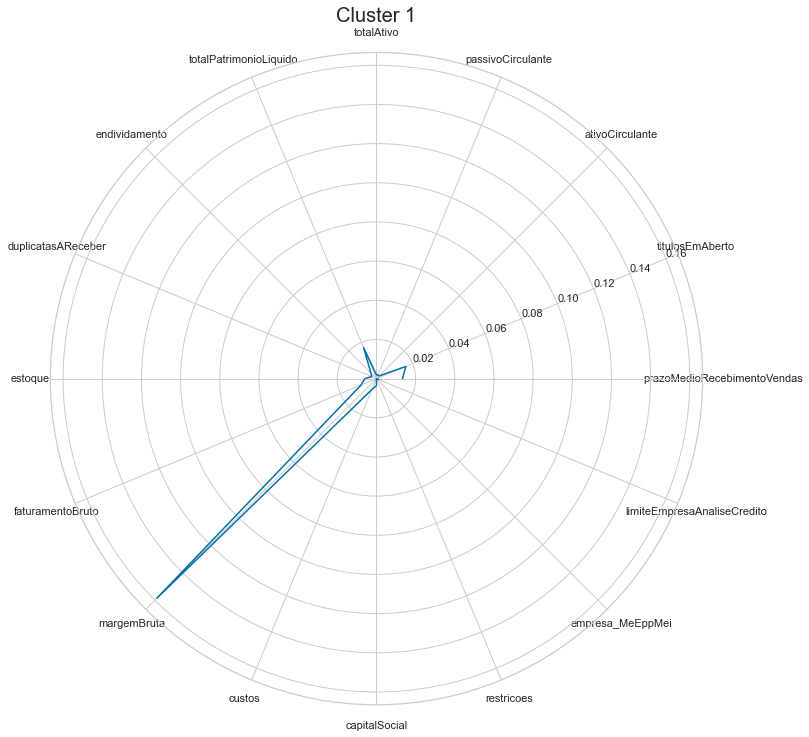

In [27]:
spider_plot_rt(df_mmsc , 1)

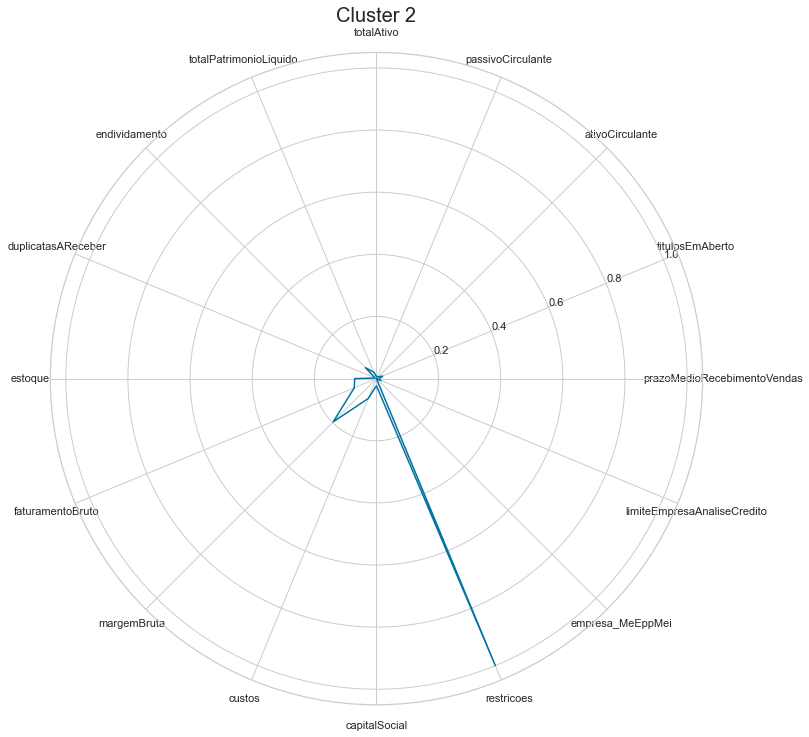

In [28]:
spider_plot_rt(df_mmsc, 2)

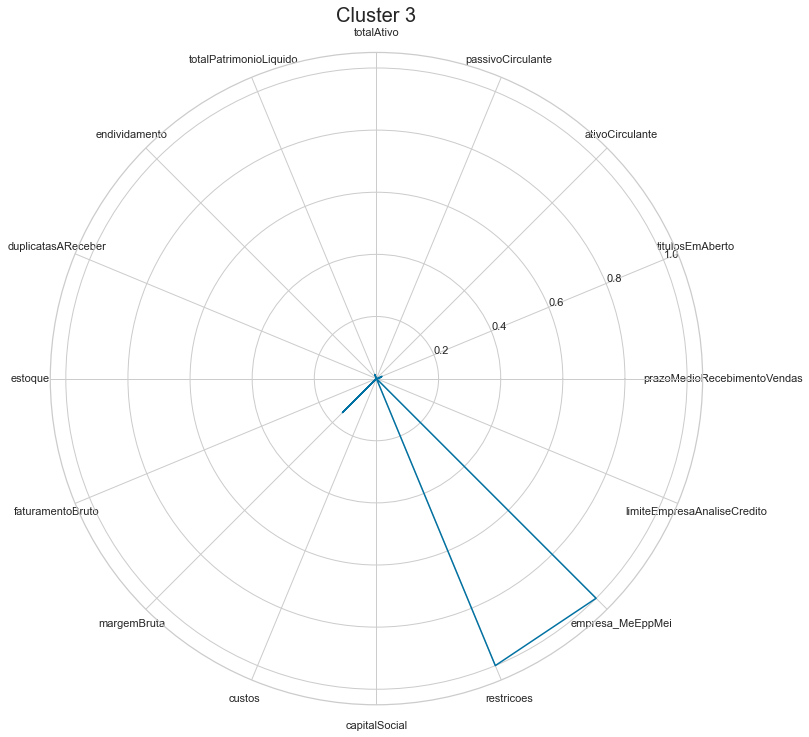

In [29]:
spider_plot_rt(df_mmsc, 3)